# Single Cell Analysis of D7, D14 and D21 RGC-iNs

In [22]:
import scanpy as sc
import pandas as pd

sc.settings.verbosity = 3 # hints 

### Data collection

In [23]:
### Read data into an AnnData objects (this step may take a few minutes the first time) ###

adata_7 = sc.read_10x_mtx(
    f'./../../sc_data/d7/',
    var_names='gene_symbols',
    cache=True
)

adata_14 = sc.read_10x_mtx(
    f'./../../sc_data/d14/',
    var_names='gene_symbols',
    cache=True
)

adata_21 = sc.read_10x_mtx(
    f'./../../sc_data/d21/',
    var_names='gene_symbols',
    cache=True
)

data = [adata_7, adata_14, adata_21]

for adata in data:
    adata.var_names_make_unique()
    display(adata)

... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time


AnnData object with n_obs × n_vars = 3440 × 37468
    var: 'gene_ids', 'feature_types'

AnnData object with n_obs × n_vars = 1665 × 37468
    var: 'gene_ids', 'feature_types'

AnnData object with n_obs × n_vars = 2380 × 37468
    var: 'gene_ids', 'feature_types'

In [12]:
# Add 'sample' column in order to later distinguish cells from different timepoints
adata_7.obs['sample'] = 'd7'
adata_14.obs['sample'] = 'd14'
adata_21.obs['sample'] = 'd21'

# Concatenate into one AnnData
adata = adata_7.concatenate(adata_14, adata_21)
display(adata)

/home/wahlinlab/miniconda3/envs/single_cell/lib/python3.10/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


AnnData object with n_obs × n_vars = 7485 × 37468
    obs: 'sample', 'batch'
    var: 'gene_ids', 'feature_types'

### Preprocessing

filtered out 2211 genes that are detected in less than 3 cells


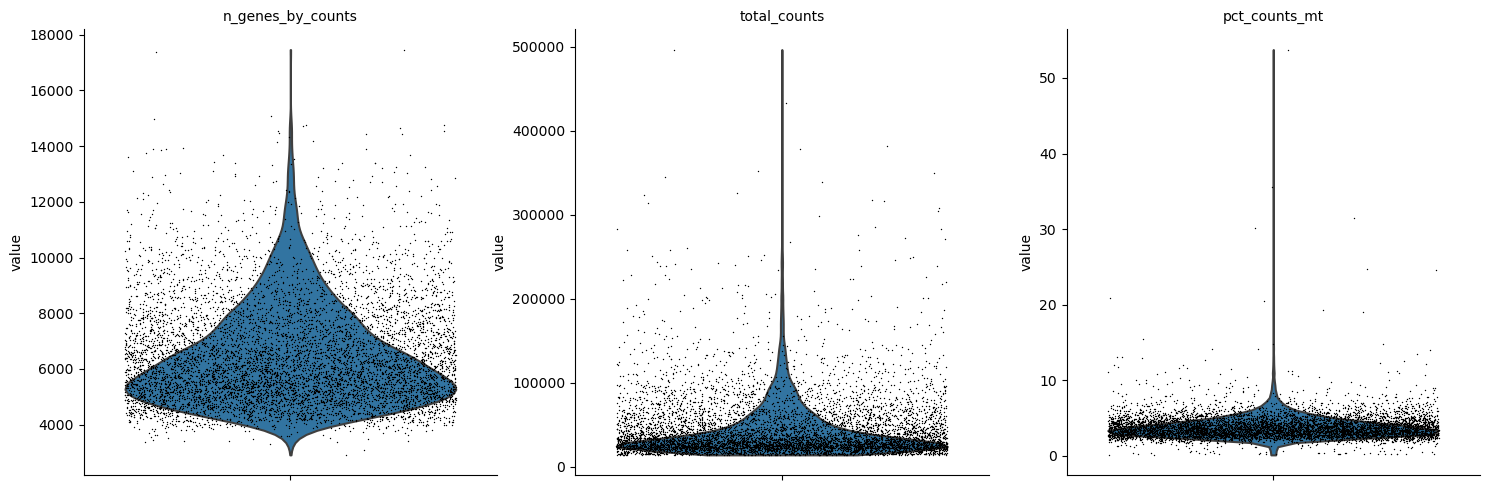

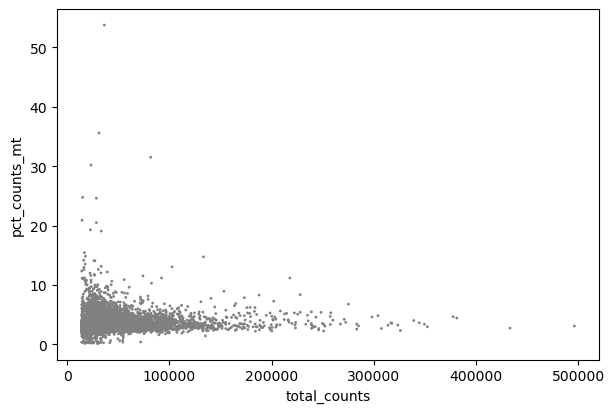

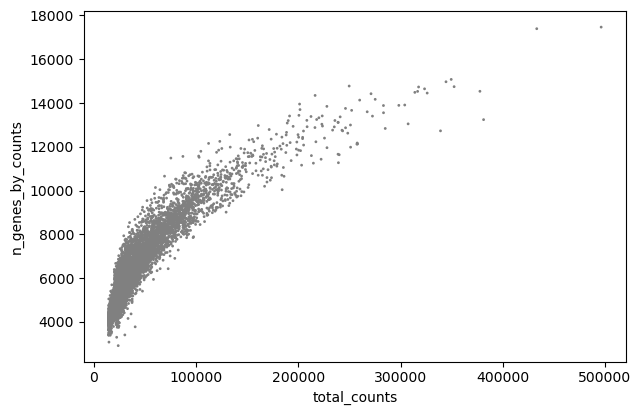

In [13]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# annotate the group of mitochondrial genes as 'mt' for later removal
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# generate plots to assess cell/transcript quality
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [14]:
# filter out cells with an abnormal number of total_counts and those with high mitochondrial gene presence
adata = adata[adata.obs.total_counts < 200000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

# normalize and logarthmize data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

display(adata)

normalizing counts per cell
    finished (0:00:00)


/home/wahlinlab/miniconda3/envs/single_cell/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 6329 × 35257
    obs: 'sample', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

### Clustering and Dimensionality Reduction

computing PCA
    with n_comps=50
    finished (0:00:12)


/home/wahlinlab/miniconda3/envs/single_cell/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


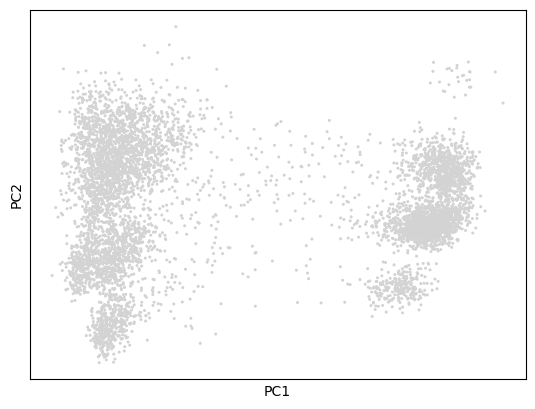

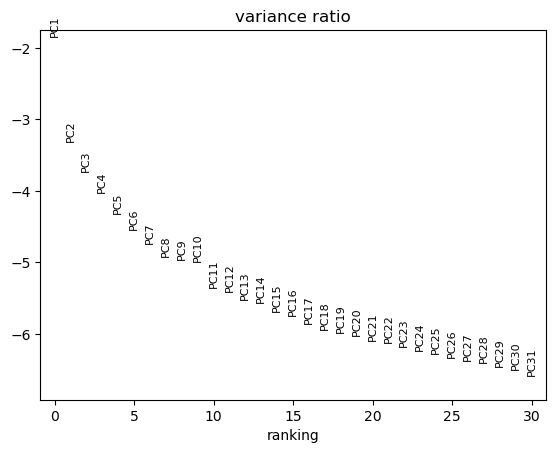

In [16]:
# compute principle components using scanpy and visualize PC1/PC2 and the variance ratios
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=False)
sc.pl.pca(adata)
sc.pl.pca_variance_ratio(adata, log=True)

In [17]:
# neighborhood generation, louvain clustering, and UMAP dimensionality reduction
sc.pp.neighbors(adata)
sc.tl.louvain(adata)
sc.tl.umap(adata, n_components=3)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


### UMAP Visualization

/home/wahlinlab/miniconda3/envs/single_cell/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


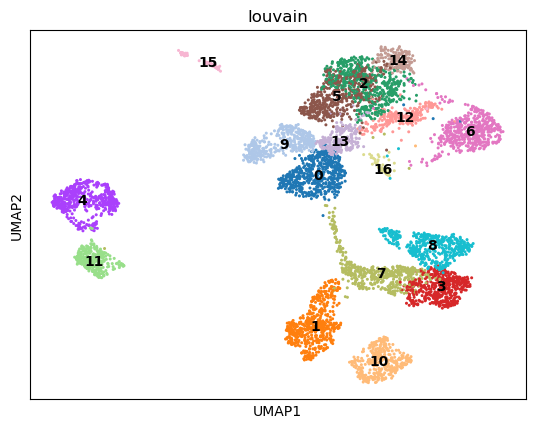

/home/wahlinlab/miniconda3/envs/single_cell/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


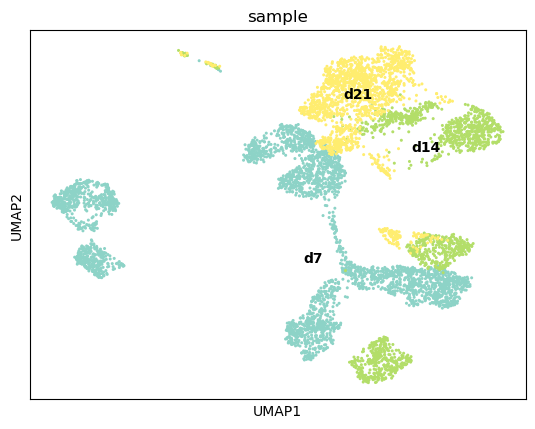

In [18]:
# plot UMAPs colored for Louvain clusters and for timepoint
sc.pl.umap(adata, color=['louvain'], legend_loc='on data', save='_all_timepoints_louvain.pdf')
sc.pl.umap(adata, color=['sample'], palette='Set3', legend_loc='on data', save='_all_timepoints.pdf')

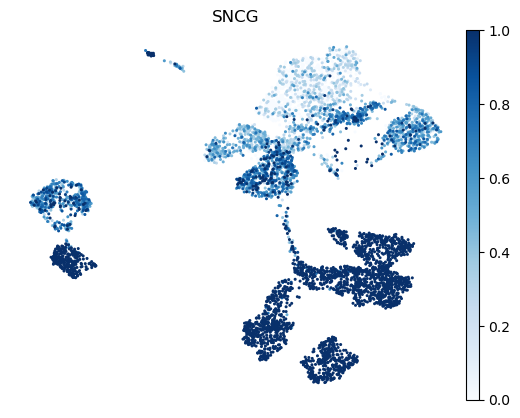

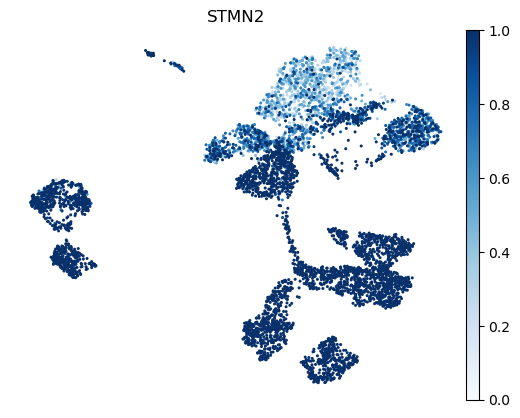

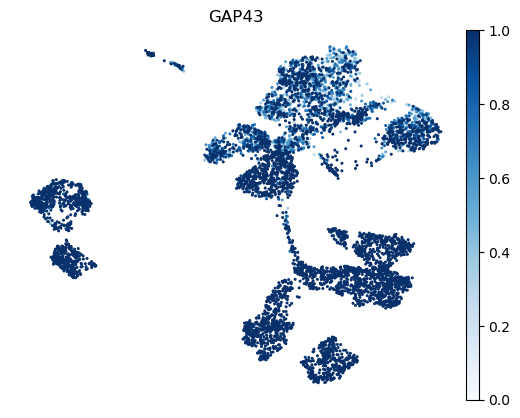

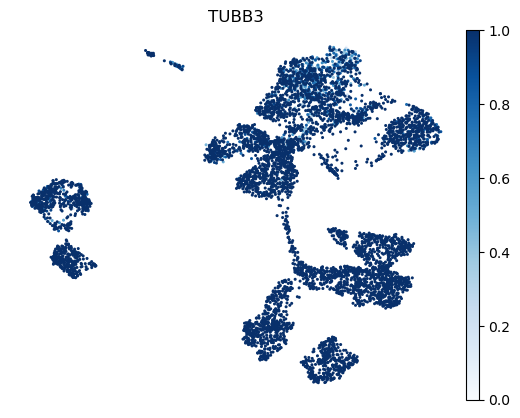

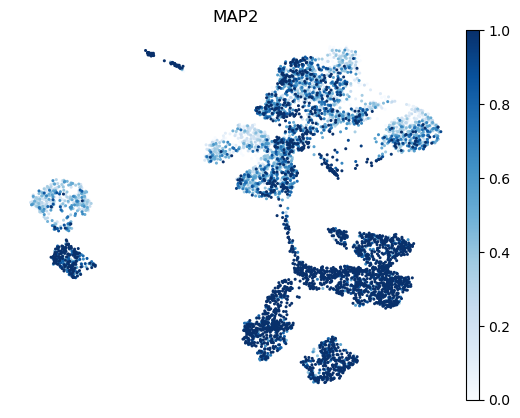

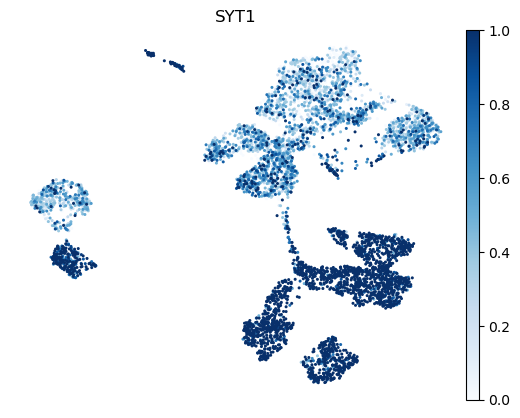

In [19]:
# generate UMAPs colored for expression of various pan-neuronal and RGC marker genes
sc.pl.umap(adata, color=['SNCG'], frameon=False, save='_all_timepoints_sncg.pdf', vmax=1, cmap='Blues')
sc.pl.umap(adata, color=['STMN2'], frameon=False, save='_all_timepoints_stmn2.pdf', vmax=1, cmap='Blues')
sc.pl.umap(adata, color=['GAP43'], frameon=False, save='_all_timepoints_gap43.pdf', vmax=1, cmap='Blues')
sc.pl.umap(adata, color=['TUBB3'], frameon=False, save='_all_timepoints_tubb3.pdf', vmax=1, cmap='Blues')
sc.pl.umap(adata, color=['MAP2'], frameon=False, save='_all_timepoints_map2.pdf', vmax=1, cmap='Blues')
sc.pl.umap(adata, color=['SYT1'], frameon=False, save='_all_timepoints_syt1.pdf', vmax=1, cmap='Blues')

### RGC Subtype Analysis

/home/wahlinlab/miniconda3/envs/single_cell/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


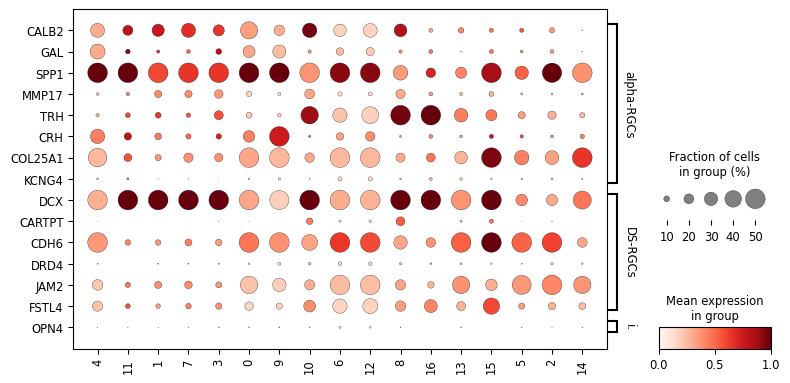

In [20]:
# create dotplot for analysis of cluster-by-cluster RGC subtype marker expression
subtypes = {
    'alpha-RGCs':['CALB2','GAL','SPP1', 'MMP17','TRH', 'CRH', 'COL25A1', 'KCNG4'],
    'DS-RGCs':['DCX', 'CARTPT', 'CDH6', 'DRD4', 'JAM2', 'FSTL4'],
    'ipRGCs':'OPN4'
}
sc.pl.dotplot(
    adata, subtypes, groupby='louvain',
    vmax=1, mean_only_expressed=True, dot_max=0.5,
    categories_order=['4', '11', '1', '7', '3', '0', '9', '10', '6', '12', '8', '16', '13', '15', '5', '2', '14'],
    title='RGC Subtype Markers',
    swap_axes=True,
    figsize=[9, 4.0],
    save='_all_timepoints_rgcsubtypes.pdf'
)

### Cell Type Analysis

/home/wahlinlab/miniconda3/envs/single_cell/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


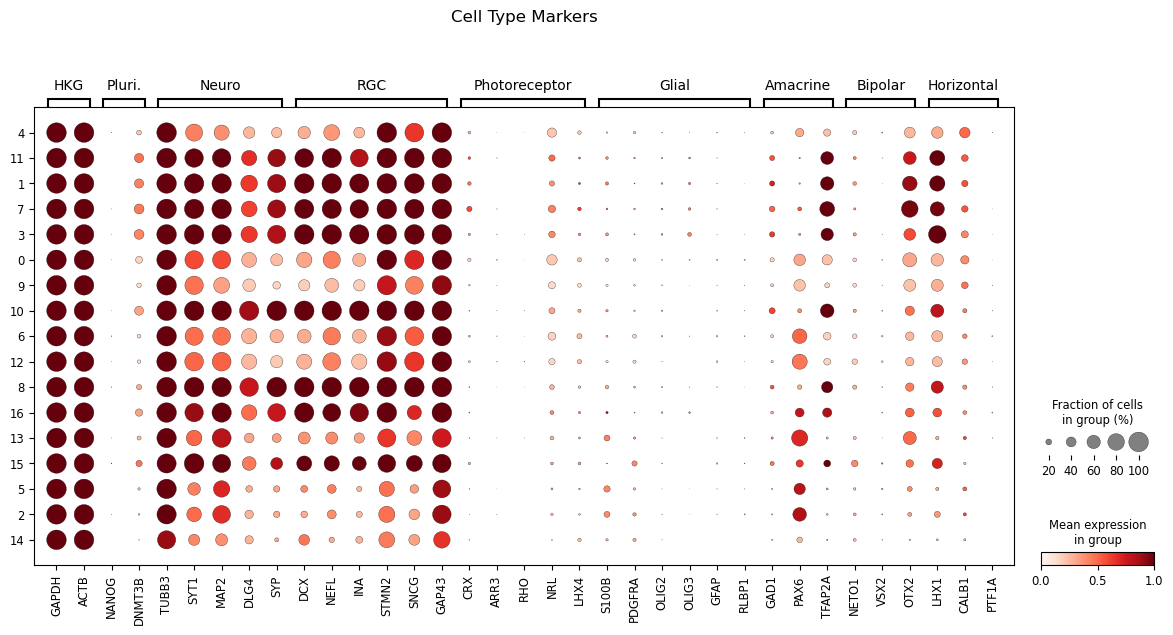

In [21]:
# create dotplot for analysis of cluster-by-cluster cell type marker gene expression
subtypes = {
    'HKG':['GAPDH', 'ACTB'],
    'Pluri.':['NANOG', 'DNMT3B'],
    'Neuro':['TUBB3', 'SYT1', 'MAP2', 'DLG4', 'SYP'],
    'RGC':['DCX', 'NEFL', 'INA', 'STMN2', 'SNCG', 'GAP43'],
    'Photoreceptor':['CRX', 'ARR3', 'RHO', 'NRL', 'LHX4'],
    'Glial':['S100B', 'PDGFRA', 'OLIG2', 'OLIG3', 'GFAP', 'RLBP1'],
    'Amacrine':['GAD1', 'PAX6', 'TFAP2A'],
    'Bipolar':['NETO1', 'VSX2', 'OTX2'],
    'Horizontal':['LHX1', 'CALB1', 'PTF1A']
}
sc.pl.dotplot(adata, subtypes, groupby='louvain',
                vmax=1, mean_only_expressed=True, dot_max=1,
                categories_order=['4', '11', '1', '7', '3', '0', '9', '10', '6', '12', '8', '16', '13', '15', '5', '2', '14'],
                title='Cell Type Markers',
                var_group_rotation=0,
                save='d7-21_celltype_dotplot.pdf'
)

Written by Manan Chopra (m1chopra@ucsd.edu) @ Wahlin Lab  
Last updated on May 15, 2023